In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = models.resnet50(pretrained=True).to(device)
model.eval()


model = nn.Sequential(*list(model.children())[:-1])


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def extract_features(image, model):
    image = Image.fromarray(image)
    img = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        features = model(img).squeeze().cpu().numpy()

    return features.flatten()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


In [ ]:
dataset_dir = "/content/drive/MyDrive/Project_NCKH/animals"
image_filenames = os.listdir(dataset_dir)[:500]

image_features = []
for filename in image_filenames :
    filepath = os.path.join(dataset_dir,filename)
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_features.append(extract_features(image, model))

In [ ]:
def cosine_similarity(query_vector, src_vectors):
    query_norm = np.linalg.norm(query_vector)
    normalized_query = query_vector / query_norm
    src_norms = np.linalg.norm(src_vectors, axis=1)
    normalized_src = src_vectors / src_norms[:, np.newaxis]

    cosine_similarity = np.dot(normalized_src, normalized_query)

    return cosine_similarity

In [ ]:
def ranking(preprocessed_query_image, preprocessed_src_images, top_k):
    scores = cosine_similarity(
        preprocessed_query_image,
        preprocessed_src_images
    )
    ranked_list = np.argsort(scores)[:: -1][: top_k]
    scores = scores[ranked_list]

    return ranked_list, scores

In [ ]:
query_image_paths = "/content/drive/MyDrive/Project_NCKH/animals/0009fc27d9.jpg"
top_k = 5

Query Image


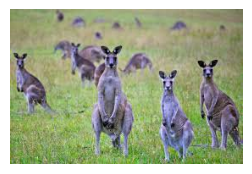

Top 5 results


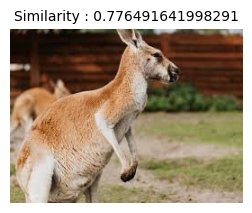

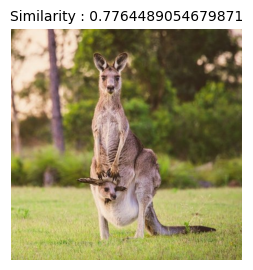

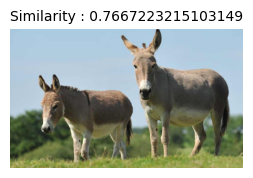

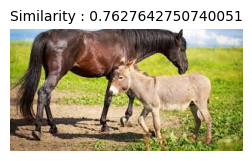

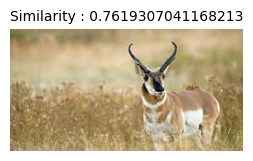

In [ ]:
query_image = cv2.imread(query_image_paths, 1)
query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
preprocessed_query_image = extract_features(query_image, model)

ranked_list, scores = ranking(
    preprocessed_query_image,
    image_features,
    top_k
)

print("Query Image")
plt.figure(figsize=(3, 3))
plt.imshow(query_image)
plt.axis("off")
plt.show()
print(f"Top {top_k} results")
for idx in range(len(ranked_list)):
    src_image_idx = ranked_list[idx]
    similarity_score = scores[idx]
    plt.figure(figsize=(3, 3))
    image_path = os.path.join(dataset_dir, image_filenames[src_image_idx])
    src_image = cv2.imread(image_path)
    src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
    plt.imshow(src_image)
    plt.title(f"Similarity : {similarity_score}", fontsize=10)
    plt.axis("off")
    plt.show()